# Introduction

Music classification has become an increasingly prominent research area within the fields of artificial intelligence (AI) and music information retrieval (MIR), aiming to automatically identify the composer or genre of a given musical work. With the advancement of deep learning, particularly architectures like Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks, it is now possible to extract and learn intricate temporal and structural patterns in musical compositions. The present project focuses on classifying musical scores from four prominent classical composers which are Johann Sebastian Bach, Ludwig van Beethoven, Frédéric Chopin, and Wolfgang Amadeus Mozart by using MIDI representations of their compositions.

The dataset, sourced from Kaggle, contains MIDI files labeled by composer, allowing for targeted selection of the required composers. MIDI files provide a structured, symbolic representation of music that includes notes, chords, tempo, and other performance information, enabling efficient feature extraction and modeling. The methodology involves preprocessing the scores, extracting relevant musical features, and building deep learning models to perform classification. By combining CNNs for local feature extraction and LSTMs for sequential temporal learning, the project aims to achieve robust composer class8ification. This approach not only advances computational musicology but also demonstrates the capabilities of modern AI techniques in understanding and interpreting complex artistic data (Humphrey et al., 2013).


In [ ]:
!unzip /content/MCC_Dataset.zip

In [ ]:
!pip install pretty_midi

In [ ]:
!pip install miditoolkit

In [ ]:
import os
import numpy as np
import pickle
from tqdm import tqdm
from miditoolkit import MidiFile
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import os, json, hashlib
from pathlib import Path
from typing import List, Tuple, Dict
import pretty_midi
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_fscore_support



# Data Collection & EDA

## Sample selection



In [ ]:
midi_path = "/content/MCC_Dataset/Chopin/Ballad op32.mid"
midi = MidiFile(midi_path)

print(f"Loaded {midi_path}")

Loaded /content/MCC_Dataset/Chopin/Ballad op32.mid


## Sample Preperation

In [ ]:
ticks_per_beat = midi.ticks_per_beat

all_notes = []
for inst in midi.instruments:
    all_notes.extend(inst.notes)

all_notes.sort(key=lambda n: n.start)

## Sample Feature Extraction

In [ ]:
start_times = np.array([note.start for note in all_notes])
pitches = np.array([note.pitch for note in all_notes])
velocities = np.array([note.velocity for note in all_notes])
durations = np.array([note.end - note.start for note in all_notes])

if midi.tempo_changes:
    bpm = midi.tempo_changes[0].tempo
    tick_duration_sec = 60.0 / (bpm * ticks_per_beat)
    times_sec = start_times * tick_duration_sec
else:
    times_sec = start_times

## Feature Visualization

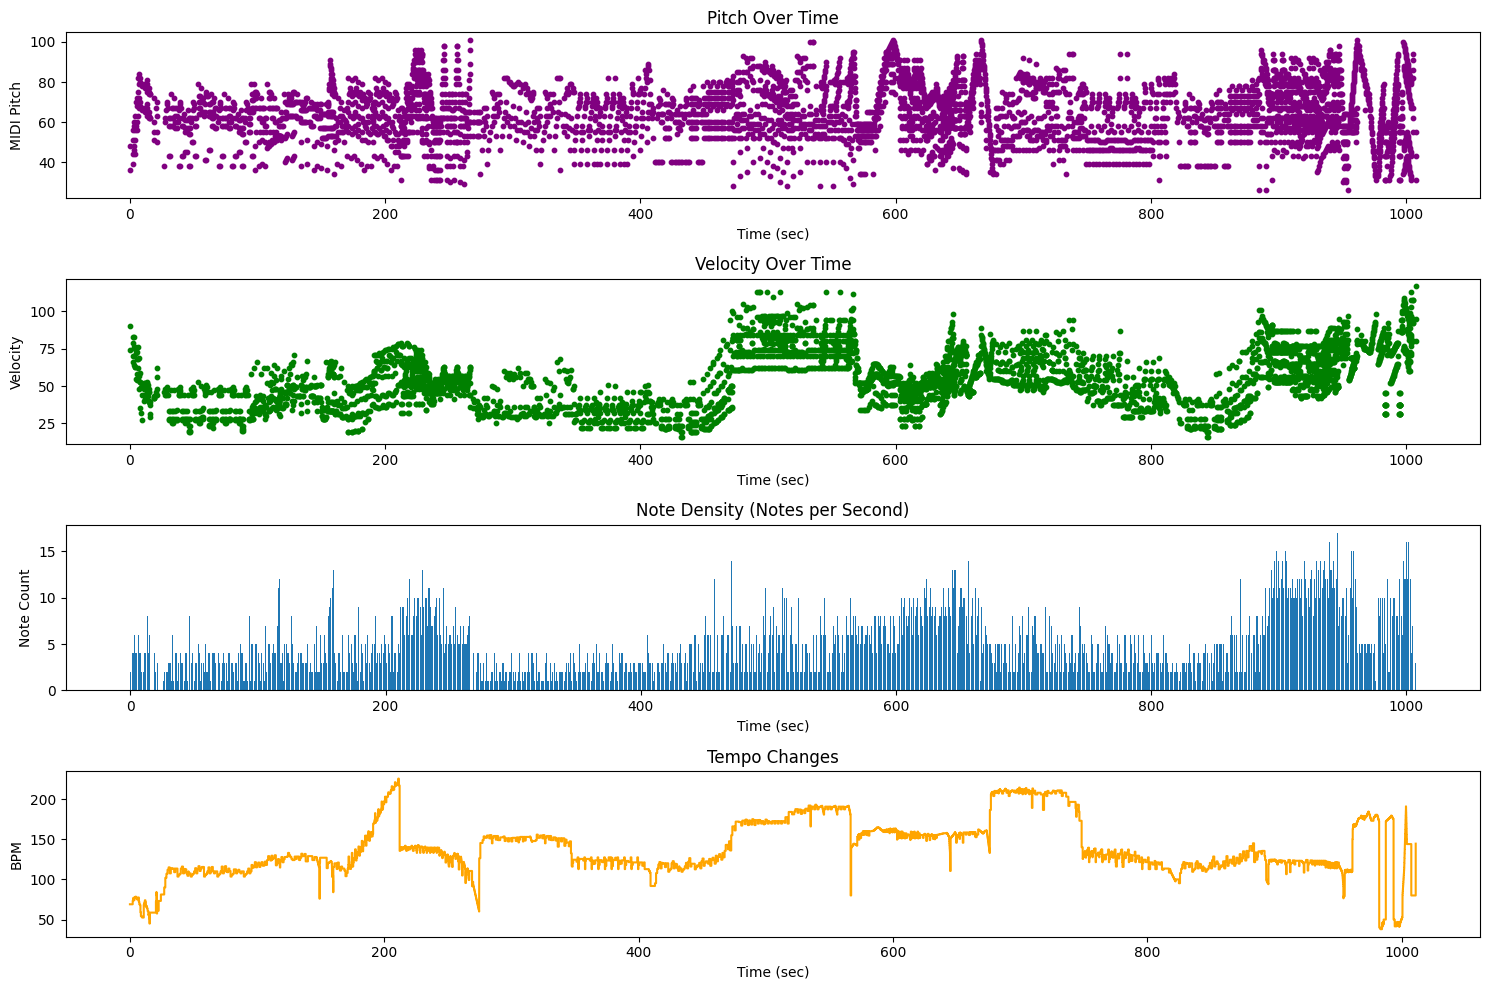

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.scatter(times_sec, pitches, s=10, c='purple')
plt.title("Pitch Over Time")
plt.xlabel("Time (sec)")
plt.ylabel("MIDI Pitch")

plt.subplot(4, 1, 2)
plt.scatter(times_sec, velocities, s=10, c='green')
plt.title("Velocity Over Time")
plt.xlabel("Time (sec)")
plt.ylabel("Velocity")

plt.subplot(4, 1, 3)
density_time = np.floor(times_sec)
count = Counter(density_time)
bins = sorted(count.keys())
values = [count[b] for b in bins]
plt.bar(bins, values, width=0.8)
plt.title("Note Density (Notes per Second)")
plt.xlabel("Time (sec)")
plt.ylabel("Note Count")

plt.subplot(4, 1, 4)
tempo_times = [t.time * tick_duration_sec for t in midi.tempo_changes]
tempo_vals = [t.tempo for t in midi.tempo_changes]
plt.step(tempo_times, tempo_vals, where='post', color='orange')
plt.title("Tempo Changes")
plt.xlabel("Time (sec)")
plt.ylabel("BPM")

plt.tight_layout()
plt.show()

In [ ]:
SAMPLE_MIDI = "/content/MCC_Dataset/Chopin/Ballad op32.mid"

def get_bpm(midi):
    if hasattr(midi, 'tempo_changes') and midi.tempo_changes:
        return midi.tempo_changes[0].tempo
    return 120.0

def calc_pitch_entropy(notes):
    pitches = [n.pitch for n in notes]
    if not pitches:
        return 0.0
    hist = np.bincount(pitches, minlength=128)
    probs = hist / hist.sum() if hist.sum() > 0 else np.ones(128) / 128
    return float(entropy(probs))

def get_stats(notes):
    arr = np.array([[n.pitch, n.velocity, n.end - n.start] for n in notes])
    if arr.shape[0] == 0:
        return [0.] * 6
    return [
        float(np.mean(arr[:,0])), float(np.std(arr[:,0])),
        float(np.mean(arr[:,1])), float(np.std(arr[:,1])),
        float(np.mean(arr[:,2])), float(np.std(arr[:,2]))
    ]

midi = MidiFile(SAMPLE_MIDI)
melody_track = None
max_notes = 0
for track in midi.instruments:
    if track.is_drum:
        continue
    if len(track.notes) > max_notes:
        max_notes = len(track.notes)
        melody_track = track

if melody_track is None or max_notes == 0:
    raise ValueError("No valid non-drum melody track with notes found in this MIDI.")

notes = sorted(melody_track.notes, key=lambda n: n.start)
pitches, velocities, durations, rests = [], [], [], []
prev_end = 0
for n in notes:
    pitches.append(n.pitch)
    velocities.append(n.velocity)
    durations.append(n.end - n.start)
    rest = n.start - prev_end if prev_end > 0 else 0
    rests.append(rest)
    prev_end = n.end

pitches = np.array(pitches)
velocities = np.array(velocities)
durations = np.array(durations)
rests = np.array(rests)
idx = np.arange(len(pitches))


bpm = get_bpm(midi)
pitch_ent = calc_pitch_entropy(notes)
m_pitch_mean, m_pitch_std, m_vel_mean, m_vel_std, m_dur_mean, m_dur_std = get_stats(notes)




In [ ]:
print("=== Global Stats ===")
print(f"File: {os.path.basename(SAMPLE_MIDI)}")
print(f"BPM: {bpm:.2f}")
print(f"Pitch entropy: {pitch_ent:.4f}")
print(f"Pitch mean/std: {m_pitch_mean:.2f} / {m_pitch_std:.2f}")
print(f"Velocity mean/std: {m_vel_mean:.2f} / {m_vel_std:.2f}")
print(f"Duration mean/std (ticks): {m_dur_mean:.2f} / {m_dur_std:.2f}")
print(f"Total notes: {len(pitches)}")


=== Global Stats ===
File: Ballad op32.mid
BPM: 69.03
Pitch entropy: 3.6703
Pitch mean/std: 73.20 / 10.70
Velocity mean/std: 61.08 / 18.36
Duration mean/std (ticks): 326.83 / 349.68
Total notes: 2852


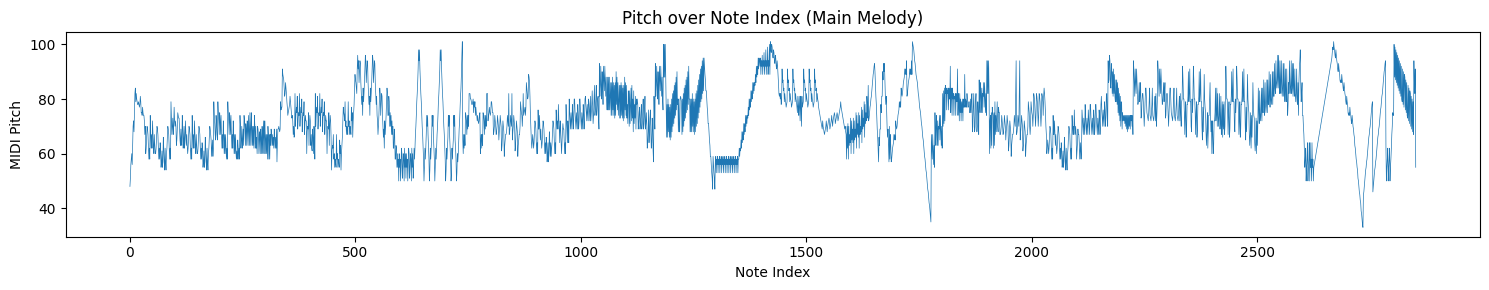

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(idx, pitches, linewidth=0.5)
plt.title("Pitch over Note Index (Main Melody)")
plt.xlabel("Note Index")
plt.ylabel("MIDI Pitch")
plt.tight_layout()
plt.show()

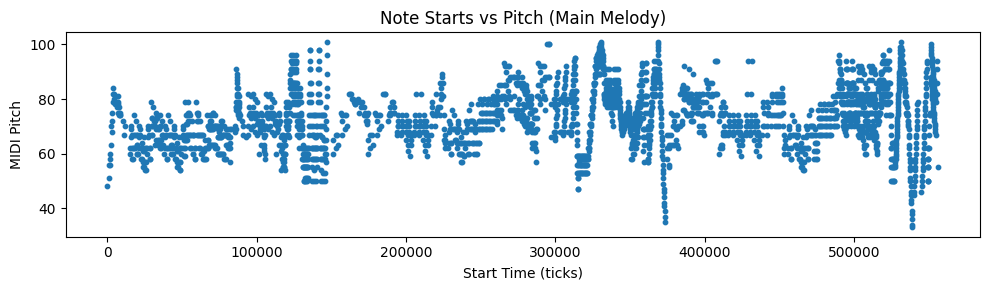

In [ ]:
starts = np.array([n.start for n in notes])
plt.figure(figsize=(10, 3))
plt.scatter(starts, pitches, s=10)
plt.title("Note Starts vs Pitch (Main Melody)")
plt.xlabel("Start Time (ticks)")
plt.ylabel("MIDI Pitch")
plt.tight_layout()
plt.show()

## Analysis

Upon performing exploratory data analysis (EDA) on several sample MIDI files, we plotted the pitch, velocity, note density, and tempo over time for entire compositions (Figure X). While these visualizations provided an overview of the musical structure, they also revealed significant complexity and variability across all instrumental tracks. The presence of multiple simultaneous voices, harmonies, and accompaniment patterns created highly dense and irregular feature sequences. These overlapping elements introduce noise from a classification perspective, as stylistic signatures of the composer may be diluted by secondary voices that are less representative of the main thematic material. Recognizing this, we concluded that training the model on all notes from every track would make it more difficult for the LSTM to learn consistent temporal and structural patterns unique to each composer. Consequently, we refined the preprocessing pipeline to extract only the main melody track for each piece, which was identified as the non-drum track with the highest note count. This approach allowed us to isolate the most salient musical line that likely carries the strongest composer-specific features, reduce feature noise, and increase the likelihood of the model learning meaningful stylistic patterns.

# LSTM

## Methodology

The proposed methodology combines symbolic music processing with deep learning to classify MIDI compositions by composer. First, the dataset was curated to include only works by Johann Sebastian Bach, Ludwig van Beethoven, Frédéric Chopin, and Wolfgang Amadeus Mozart. MIDI files were preprocessed to isolate the main melody track for each piece, ensuring that the most prominent musical line was used as the basis for feature extraction. For each note, local features such as pitch, velocity, duration, and inter-note rest times were extracted, while global musical descriptors like beats per minute (BPM), pitch entropy, and statistical measures of note distributions were computed to capture overall compositional characteristics. These features were segmented into overlapping fixed-length sequences to create multiple training samples from each piece, increasing data diversity. Feature scaling was applied to global statistics to standardize their ranges. The resulting sequences were used to train a bidirectional Long Short-Term Memory (BiLSTM) neural network, which captures both forward and backward temporal dependencies in the music. The model’s performance was evaluated using accuracy metrics on separate training, validation, and test splits, and optimization was carried out through early stopping and learning rate scheduling to prevent overfitting and improve convergence. This approach leverages both local note-level detail and global compositional style to enhance classification accuracy.

## Data Preperation & Feature Extraction

### Configurations

In [ ]:
DATASET_ROOT = '/content/MCC_Dataset'
SEQ_LENGTH = 500
WINDOW_STRIDE = 250
SAVE_PATH_X = 'X_multi_seq_rest.npy'
SAVE_PATH_Y = 'y_multi_seq_rest.npy'
LABEL_ENCODER_PATH = 'label_encoder_multi_seq_rest.pkl'
STATS_SCALER_PATH = 'stats_scaler_multi_seq_rest.pkl'

This configuration block defines the core parameters and file paths used throughout the data processing pipeline.

**DATASET_ROOT** specifies the root directory containing the organized MIDI dataset.

**SEQ_LENGTH** determines the fixed length, in notes, of each feature sequence fed into the model, while WINDOW_STRIDE controls the overlap between consecutive sequences to increase training samples and capture continuity.

**SAVE_PATH_X** and **SAVE_PATH_Y** define where the extracted feature sequences and their corresponding encoded labels are stored as NumPy arrays.

**LABEL_ENCODER_PATH** is the file path for saving the fitted label encoder, which converts composer names into numeric class indices.

**STATS_SCALER_PATH** stores the fitted feature scaler for global statistical features, ensuring consistent normalization during model training and inference.

### Feature Extraction

In [ ]:
def get_bpm(midi):
    """
    Retrieve the tempo (beats per minute) from a MIDI object.

    Args:
        midi: A MIDI object that may contain tempo changes.

    Returns:
        float: The tempo in beats per minute (BPM). Defaults to 120.0 if no tempo changes are found.
    """
    if hasattr(midi, 'tempo_changes') and midi.tempo_changes:
        return midi.tempo_changes[0].tempo
    return 120.0

def calc_pitch_entropy(notes):
    """
    Calculate the pitch entropy of a list of MIDI notes.

    Pitch entropy measures the diversity of pitches.

    Args:
        notes (list): List of note objects, each with a 'pitch' attribute.

    Returns:
        float: The entropy value of the pitch distribution. Returns 0.0 if no notes are provided.
    """
    pitches = [n.pitch for n in notes]
    if not pitches: return 0.0
    hist = np.bincount(pitches, minlength=128)
    probs = hist / hist.sum() if hist.sum() > 0 else np.ones(128) / 128
    return float(entropy(probs))

def get_stats(notes):
    """
    Compute basic statistics for pitch, velocity, and duration from MIDI notes.

    Args:
        notes (list): List of note objects, each with 'pitch', 'velocity', 'start', and 'end' attributes.

    Returns:
        list: A list containing six floats:
            - Mean pitch
            - Standard deviation of pitch
            - Mean velocity
            - Standard deviation of velocity
            - Mean duration (end - start)
            - Standard deviation of duration
            Returns all zeros if no notes are provided.
    """
    arr = np.array([[n.pitch, n.velocity, n.end - n.start] for n in notes])
    if arr.shape[0] == 0:
        return [0.] * 6
    return [
        float(np.mean(arr[:,0])), float(np.std(arr[:,0])),
        float(np.mean(arr[:,1])), float(np.std(arr[:,1])),
        float(np.mean(arr[:,2])), float(np.std(arr[:,2]))
    ]

This section defines helper functions for extracting global statistical features from each MIDI file.

***get_bpm*** retrieves the first recorded tempo change in the file to estimate beats per minute, defaulting to 120 BPM if no tempo data is available.

***calc_pitch_entropy*** measures the distribution diversity of note pitches using Shannon entropy, providing a quantitative representation of melodic variability.

***get_stats*** computes the mean and standard deviation for three core note-level attributes: pitch, velocity, and duration.

Together, these descriptors summarize the overall musical structure and style, which are later combined with per-note features to enhance the model’s ability to capture composer-specific characteristics.

In [ ]:
def extract_main_melody_chunks(midi_path, seq_length=SEQ_LENGTH, stride=WINDOW_STRIDE, stats_scaler=None):
    """
    Extract overlapping fixed-length feature sequences from the main melody of a MIDI file.

    This function processes a MIDI file to extract the main melody's note features and global statistics,
    returning them as fixed-length sequences suitable for modeling. It handles errors gracefully and returns
    an empty list if processing fails.

    Args:
        midi_path (str): Path to the MIDI file.
        seq_length (int): Length of each sequence window.
        stride (int): Step size between windows.
        stats_scaler (optional): Scaler to normalize global features.

    Returns:
        List[np.ndarray]: List of feature arrays ready for model input or empty if processing fails.
    """
    try:
        midi = MidiFile(midi_path)
        melody_track = None
        max_notes = 0
        for track in midi.instruments:
            if track.is_drum: continue
            if len(track.notes) > max_notes:
                max_notes = len(track.notes)
                melody_track = track

        if melody_track is None or max_notes == 0:
            return []

        notes = sorted(melody_track.notes, key=lambda n: n.start)

        features = []
        prev_end = 0
        for n in notes:
            rest = n.start - prev_end if prev_end > 0 else 0
            features.append([n.pitch, n.velocity, n.end - n.start, rest])
            prev_end = n.end

        bpm = get_bpm(midi)
        pitch_ent = calc_pitch_entropy(notes)
        stats = get_stats(notes)
        global_stats = np.array([bpm, pitch_ent] + stats, dtype=np.float32)
        if stats_scaler is not None:
            global_stats = stats_scaler.transform(global_stats.reshape(1, -1))[0]
        global_stats_seq = np.tile(global_stats, (seq_length, 1))

        num_notes = len(features)
        chunks = []
        for start in range(0, num_notes, stride):
            window = features[start:start + seq_length]
            padded = pad_sequences([window], maxlen=seq_length, padding='post', truncating='post')[0]
            feat_with_stats = np.concatenate([padded, global_stats_seq], axis=1)
            chunks.append(feat_with_stats)
            if start + seq_length >= num_notes:
                break
        return chunks

    except Exception as e:
        print(f"Error in {midi_path}: {e}")
        return []

This function converts a single MIDI file into model-ready sequences centered on the main melody. It first selects the non-drum instrument with the most notes as the melody track and orders its notes by start time. For each note it builds local features: pitch, velocity, duration, and the inter-note rest. It then computes global descriptors for the whole piece (BPM, pitch entropy, and the mean and standard deviation of pitch, velocity, and duration), scales them, and tiles this 8-value vector across the sequence length so every timestep carries the same global context. The note stream is segmented into overlapping windows of length seq_length with stride stride; each window is padded or truncated to a fixed length and concatenated with the tiled global stats, producing sequences of shape (seq_length, 12). Any files that fail to parse safely return an empty list.

In [ ]:
stats_list = []
for composer in os.listdir(DATASET_ROOT):
    composer_path = os.path.join(DATASET_ROOT, composer)
    if not os.path.isdir(composer_path): continue
    for root, _, files in os.walk(composer_path):
        for file in files:
            if file.lower().endswith('.mid'):
                midi_path = os.path.join(root, file)
                try:
                    midi = MidiFile(midi_path)
                    melody_track = max([t for t in midi.instruments if not t.is_drum], key=lambda t: len(t.notes), default=None)
                    if melody_track is None or len(melody_track.notes) == 0: continue
                    notes = sorted(melody_track.notes, key=lambda n: n.start)
                    bpm = get_bpm(midi)
                    pitch_ent = calc_pitch_entropy(notes)
                    stats = get_stats(notes)
                    stats_list.append([bpm, pitch_ent] + stats)
                except Exception as e:
                    continue
stats_array = np.array(stats_list)
stats_scaler = StandardScaler()
stats_scaler.fit(stats_array)
with open(STATS_SCALER_PATH, 'wb') as f:
    pickle.dump(stats_scaler, f)

In [ ]:
X, y = [], []
for composer in os.listdir(DATASET_ROOT):
    composer_path = os.path.join(DATASET_ROOT, composer)
    if not os.path.isdir(composer_path): continue

    midi_files = []
    for root, _, files in os.walk(composer_path):
        for file in files:
            if file.lower().endswith('.mid'):
                midi_files.append(os.path.join(root, file))

    for filepath in tqdm(midi_files, desc=f"Processing {composer}"):
        chunks = extract_main_melody_chunks(filepath, stats_scaler=stats_scaler)
        for chunk in chunks:
            X.append(chunk)
            y.append(composer)

X = np.array(X)
np.save(SAVE_PATH_X, X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
np.save(SAVE_PATH_Y, y_encoded)
with open(LABEL_ENCODER_PATH, 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"\nSaved {len(X)} sequences from main melodies. Shape: {X.shape}")

Processing Beethoven:   6%|▌         | 12/213 [00:01<00:12, 16.37it/s]

Error in /content/MCC_Dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Processing Mozart:  86%|████████▌ | 220/257 [00:23<00:03, 12.12it/s]

Error in /content/MCC_Dataset/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Processing Bach: 100%|██████████| 1024/1024 [00:35<00:00, 28.91it/s]



Saved 6785 sequences from main melodies. Shape: (6785, 500, 12)


This block performs dataset-wide feature extraction and serialization. For each composer directory, it gathers all MIDI file paths, extracts overlapping main-melody sequences with *extract_main_melody_chunks* using the previously fitted scaler, and appends each fixed-length sequence to X while storing the corresponding composer label in y. After processing all files, it converts X to a NumPy array and saves it, encodes string composer labels into numeric classes with LabelEncoder, saves the encoded labels, and persists the fitted encoder. The final print statement summarizes the total number of sequences and their tensor shape, confirming that the data are ready for model training.

### Test Train & Validation Split

In [ ]:
X = np.load(SAVE_PATH_X)
y = np.load(SAVE_PATH_Y)
with open(LABEL_ENCODER_PATH, 'rb') as f:
    label_encoder = pickle.load(f)

y_cat = to_categorical(y, num_classes=len(label_encoder.classes_))

X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.3, stratify=y_cat, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (4749, 500, 12), Val: (1018, 500, 12), Test: (1018, 500, 12)


This section loads the serialized feature tensor X and label vector y, restores the LabelEncoder, and converts labels to one-hot form (y_cat) for training. It then performs a two-stage, stratified split to create training (70%), validation (15%), and test (15%) sets while preserving class balance.

## Model Building

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LENGTH, 12)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 500, 256)       │       144,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 317,252 (1.21 MB)

 Trainable params: 317,252 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

This code defines the BiLSTM architecture used for composer classification.
The input layer expects sequences of length SEQ_LENGTH with 12 features per timestep (four local note features plus eight global statistics). The first bidirectional LSTM layer with 128 units captures forward and backward temporal dependencies while preserving the full sequence for the next layer. A dropout layer follows to reduce overfitting. The second bidirectional LSTM with 64 units condenses the learned temporal patterns into a fixed-size representation, followed by another dropout. A dense layer with 64 ReLU-activated units learns higher-level feature interactions, and the final softmax layer outputs class probabilities for each composer. The model is compiled with Adam optimization, categorical cross-entropy loss, and accuracy tracking.

## Model Training

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5
)
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=7, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.4916 - loss: 1.1165 - val_accuracy: 0.6169 - val_loss: 0.8555 - learning_rate: 0.0010
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.6241 - loss: 0.8794 - val_accuracy: 0.6100 - val_loss: 0.8695 - learning_rate: 0.0010
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.6783 - loss: 0.7775 - val_accuracy: 0.7161 - val_loss: 0.7309 - learning_rate: 0.0010
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7079 - loss: 0.7002 - val_accuracy: 0.6847 - val_loss: 0.7859 - learning_rate: 0.0010
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7272 - loss: 0.6776 - val_accuracy: 0.7593 - val_loss: 0.6320 - learning_rate: 0.0010
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7349 - loss: 0.6365 - val_accuracy: 0.6680 - val_loss: 0.7465 - learning_rate: 0.0010
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7418 - l

This block sets up training with two key callbacks for optimization and generalization control.

**ReduceLROnPlateau** monitors the validation loss and halves the learning rate if it fails to improve for three consecutive epochs, with a minimum rate of 1e-5, helping the model fine-tune its weights later in training.

**EarlyStopping** halts training if validation performance does not improve for seven epochs and restores the best-performing weights, preventing overfitting.
The model is trained for up to 50 epochs with a batch size of 32, using the training set for weight updates and the validation set for performance monitoring, while recording the process in the history object for later analysis.

## Model Evaluation

### Test Accuracy

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8772 - loss: 0.3467
Test accuracy: 0.8811


### Training & Validation Curves

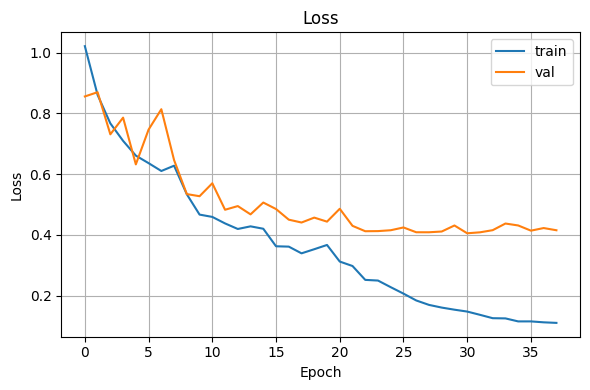

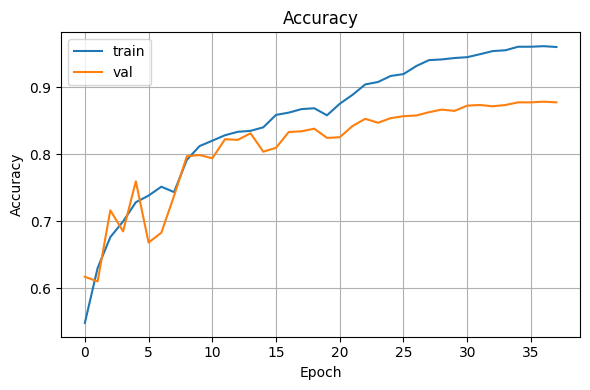

In [ ]:
def plot_training_curves(history):
    """
    Plot training and validation loss and accuracy curves from a Keras History object.

    Displays two plots:
    1. Loss vs. Epoch for training and optionally validation data.
    2. Accuracy vs. Epoch for training and optionally validation data, if accuracy metrics exist.

    Args:
        history (keras.callbacks.History): The History object returned by model.fit(),
            containing training metrics per epoch.

    Returns:
        None: Displays plots but does not return any value.
    """
    h = history.history

    plt.figure(figsize=(6,4))
    plt.plot(h['loss'], label='train')
    if 'val_loss' in h: plt.plot(h['val_loss'], label='val')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()


    if 'accuracy' in h or 'acc' in h:
        acc_key = 'accuracy' if 'accuracy' in h else 'acc'
        val_acc_key = 'val_accuracy' if 'val_accuracy' in h else ('val_acc' if 'val_acc' in h else None)
        plt.figure(figsize=(6,4))
        plt.plot(h[acc_key], label='train')
        if val_acc_key and val_acc_key in h: plt.plot(h[val_acc_key], label='val')
        plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.tight_layout()
        plt.show()

plot_training_curves(history)

The loss curve indicates that training loss consistently decreases, while validation loss drops initially and then stabilizes, suggesting the model converges without severe overfitting. The accuracy curve shows steady improvement in both training and validation accuracy, with validation accuracy leveling off slightly below training accuracy, a common sign that the model is generalizing well but still fits the training set more closely.
Together, these trends suggest that the combination of early stopping, dropout, and learning rate scheduling helped achieve stable convergence and good generalization.

## Classification Report

In [ ]:
probs = model.predict(X_test, verbose=0)
y_pred = probs.argmax(axis=1)

if y_test.ndim > 1 and y_test.shape[-1] > 1:
    y_true = y_test.argmax(axis=1)
else:
    y_true = y_test.copy()

try:
    label_names = list(label_encoder.classes_)
except:
    label_names = [str(i) for i in np.unique(y_true)]

acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Macro  P/R/F1: {prec_macro:.4f} / {rec_macro:.4f} / {f1_macro:.4f}")
print(f"Micro  P/R/F1: {prec_micro:.4f} / {rec_micro:.4f} / {f1_micro:.4f}")
print(f"Weighted P/R/F1: {prec_weighted:.4f} / {rec_weighted:.4f} / {f1_weighted:.4f}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(label_names)))
print("\nConfusion matrix:")
print(cm)


Test Accuracy: 0.8811
Macro  P/R/F1: 0.8747 / 0.8700 / 0.8718
Micro  P/R/F1: 0.8811 / 0.8811 / 0.8811
Weighted P/R/F1: 0.8831 / 0.8811 / 0.8817

Classification report:
              precision    recall  f1-score   support

        Bach     0.9469    0.9162    0.9313       370
   Beethoven     0.8632    0.8632    0.8632       285
      Chopin     0.8750    0.8235    0.8485       119
      Mozart     0.8137    0.8770    0.8442       244

    accuracy                         0.8811      1018
   macro avg     0.8747    0.8700    0.8718      1018
weighted avg     0.8831    0.8811    0.8817      1018


Confusion matrix:
[[339   8   0  23]
 [  9 246  11  19]
 [  2  12  98   7]
 [  8  19   3 214]]


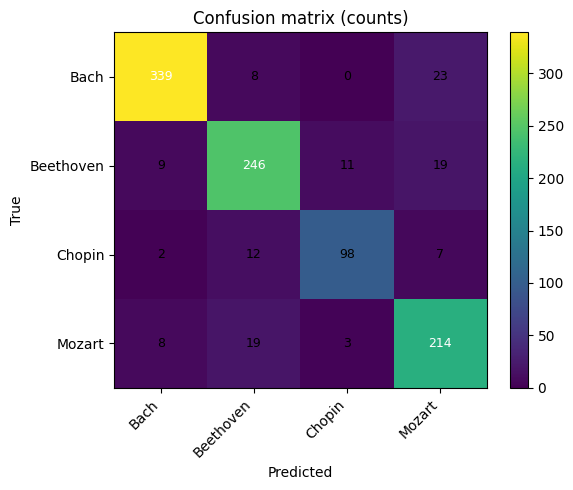

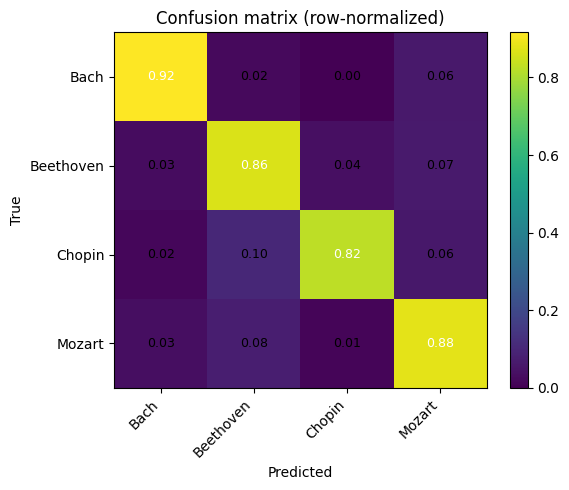

In [ ]:
def plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion matrix'):
    """
    Plot a confusion matrix with optional normalization and annotations.

    Args:
        cm (np.ndarray): Confusion matrix (2D array) with shape (num_classes, num_classes).
        class_names (list): List of class labels corresponding to the matrix indices.
        normalize (bool, optional): If True, normalize each row to sum to 1 (default is False).
        title (str, optional): Title for the plot (default is 'Confusion matrix').

    Returns:
        None: Displays a matplotlib plot of the confusion matrix with counts or normalized values.
    """
    cm_disp = cm.astype('float')
    if normalize:
        row_sums = cm_disp.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm_disp = cm_disp / row_sums

    plt.figure(figsize=(6,5))
    plt.imshow(cm_disp, aspect='auto')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
    thresh = cm_disp.max() / 2.0 if cm_disp.size else 0.0
    for i in range(cm_disp.shape[0]):
        for j in range(cm_disp.shape[1]):
            val = cm_disp[i, j]
            txt = f"{val:.2f}" if normalize else f"{int(cm[i,j])}"
            color = 'white' if val > thresh else 'black'
            plt.text(j, i, txt, ha='center', va='center', color=color, fontsize=9)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, label_names, normalize=False, title='Confusion matrix (counts)')
plot_confusion_matrix(cm, label_names, normalize=True,  title='Confusion matrix (row-normalized)')

## Analysis

The evaluation results show that the BiLSTM model achieved a test accuracy of 88.11%, with strong precision, recall, and F1-scores across all averaging schemes (macro F1: 0.8718, weighted F1: 0.8817).
The classification report indicates the highest performance for Bach (F1 = 0.9313) and solid results for Beethoven, Chopin, and Mozart, though Mozart and Chopin show slightly lower recall, suggesting occasional misclassification.
The confusion matrix reveals that most errors occur between stylistically similar composers (e.g., Mozart misclassified as Bach or Beethoven, Chopin misclassified as Beethoven).
These results confirm that the model is effectively learning composer-specific melodic and structural patterns from the main melody features, but also suggest areas for improvement, such as reducing cross-class confusions between more similar composers.

# CNN

## Methodology

For the CNN approach, we transform each MIDI file into a compact, image-like representation and train a convolutional classifier on these tensors. We first enumerate all files for the four target composers and convert each score into a three-channel piano-roll tensor with a fixed frame rate. The channels encode note onsets, binary sustain activity, and normalized velocity, producing arrays of shape (3, 128, T). We cache these tensors as .npy files and record a manifest so that subsequent runs skip MIDI parsing and feature regeneration. Caching greatly reduces preprocessing time, ensures reproducibility of the dataset used for training and evaluation, and prevents variability from repeated MIDI decoding. We perform a file-level, stratified split into training, validation, and test sets to avoid leakage. During training, each item is cropped to a fixed temporal window length, with multiple random crops per file and light time-mask augmentation to improve robustness; validation and test use a centered crop for consistency. The model is a lightweight CNN that stacks convolution, batch normalization, and pooling layers to learn local time–pitch patterns, followed by global average pooling and a linear classifier. We optimize with AdamW and a cosine annealing schedule, apply gradient clipping for stability, and select the checkpoint with the best validation macro F1. Final evaluation reports accuracy, per-class precision, recall, F1, and a confusion matrix on the held-out test set.

## Data Preperation & Feature Extraction

### Configurations

In [39]:
ROOT_DIR   = "/content/MCC_Dataset"
CACHE_DIR  = "./cache_pianorolls"
FS         = 50
TARGET_T   = 1024
CROPS_PER_FILE = 4
BATCH_SIZE = 16
EPOCHS     = 20
LR         = 2e-4
SEED       = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

This configuration block defines key parameters for the CNN training pipeline.

**ROOT_DIR** specifies the top-level dataset folder containing subfolders for each composer.

**CACHE_DIR** is where preprocessed piano-roll tensors and the manifest file will be stored to speed up future runs.

**FS** sets the temporal resolution for piano-roll extraction in frames per second.

**TARGET_T** defines the fixed number of time frames for each cropped input sample
**CROPS_PER_FILE** controls how many training crops are taken from each file to increase data diversity.

**BATCH_SIZE**, **EPOCHS**, and **LR** configure the training process.

**SEED** ensures reproducibility in dataset splitting and augmentations.

Finally, the device variable selects GPU if available, and random seeds are set for NumPy and PyTorch to produce consistent results across runs.

### Feature Extraction

In [40]:
def list_midi_pairs(root_dir: str) -> List[Tuple[str, str]]:
    """Return (filepath, top_level_label). Handles nested folders."""
    root = Path(root_dir).resolve()
    pairs = []
    for class_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        label = class_dir.name
        for f in class_dir.rglob("*"):
            if f.is_file() and f.suffix.lower() in [".mid", ".midi"]:
                pairs.append((str(f), label))
    return pairs


def safe_relpath(path: str, root: str) -> str:
    """Relative path token used for cache filenames."""
    rel = os.path.relpath(path, root)
    return str(Path(rel)).replace("\\", "/")


def midi_to_pianoroll_channels(midi_path: str, fs: int = 50) -> np.ndarray | None:
    """
    3-channel piano roll: [onsets, sustain(binary), velocity_norm] -> (3, 128, T)
    Returns None on failure or empty content.
    """
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
    except Exception:
        return None

    vel_roll = pm.get_piano_roll(fs=fs).astype(np.float32)
    if vel_roll.size == 0 or vel_roll.shape[1] == 0:
        return None

    T = vel_roll.shape[1]
    bin_roll = (vel_roll > 0).astype(np.float32)
    vel_norm = np.clip(vel_roll / 127.0, 0.0, 1.0)

    onsets = np.zeros_like(bin_roll, dtype=np.float32)
    for inst in pm.instruments:
        for note in inst.notes:
            t0 = int(np.floor(note.start * fs))
            if 0 <= t0 < T and 0 <= note.pitch < 128:
                onsets[note.pitch, t0] = 1.0

    x = np.stack([onsets, bin_roll, vel_norm], axis=0).astype(np.float32)
    return x

*list_midi_pairs:* Walks the dataset root and returns a list of (filepath, label) tuples. The label is taken from the top-level folder name (e.g., Bach, Beethoven). It supports arbitrarily nested subfolders via rglob, so deeply organized datasets are handled without extra logic.

*safe_relpath*: Produces a normalized, POSIX-style relative path string from an absolute path. This is used to mirror the dataset’s folder structure inside the cache and to generate stable cache filenames.

*midi_to_pianoroll_channels:* Converts a single MIDI file into a 3-channel piano roll tensor of shape (3, 128, T) at a chosen frame rate fs.

Loads the MIDI with pretty_midi. Returns None if parsing fails or produces an empty piano roll.

Computes vel_roll with range [0, 127].

Derives three channels:
- Onsets: a binary map with 1 at each note’s start frame (pitch, t0).

- Sustain (binary): bin_roll, indicating whether a pitch is active at each frame.

- Velocity (normalized): vel_norm = vel_roll / 127, clipped to [0, 1].

Stacks the channels into a single array and returns it as float32.
These three channels give the CNN complementary cues: precise attack timing (onsets), held-note structure over time (sustain), and expressive dynamics (velocity), all aligned on a uniform time grid.


### Cache Dataset

In [41]:
def cache_dataset(root_dir: str, cache_dir: str, fs: int = 50, force: bool = False):
    """
    Convert all MIDIs under root_dir to cached .npy rolls under cache_dir.
    Skips files that error or produce empty rolls.
    Writes a manifest.json with list of dicts: {cache_path, label, rel}
    """
    cache_root = Path(cache_dir)
    cache_root.mkdir(parents=True, exist_ok=True)
    manifest_path = cache_root / "manifest.json"

    pairs = list_midi_pairs(root_dir)
    if not pairs:
        raise RuntimeError("No MIDI files found. Check ROOT_DIR and extensions.")

    manifest = []
    skipped = []

    if manifest_path.exists() and not force:
        with open(manifest_path, "r", encoding="utf-8") as f:
            manifest = json.load(f)
        print(f"Loaded existing manifest with {len(manifest)} items.")
        return manifest, skipped

    print(f"Processing {len(pairs)} MIDI files...")
    for fp, label in tqdm(pairs, ncols=80):
        rel = safe_relpath(fp, root_dir)
        out_npy_path = cache_root / (Path(rel).with_suffix(".npy"))
        out_npy_path.parent.mkdir(parents=True, exist_ok=True)

        if out_npy_path.exists() and not force:
            manifest.append({"cache_path": str(out_npy_path), "label": label, "rel": rel})
            continue

        x = midi_to_pianoroll_channels(fp, fs=fs)
        if x is None or x.ndim != 3 or x.shape[1] != 128 or x.shape[2] == 0:
            skipped.append({"file": fp, "reason": "empty_or_error"})
            continue

        try:
            np.save(out_npy_path, x)
            manifest.append({"cache_path": str(out_npy_path), "label": label, "rel": rel})
        except Exception as e:
            skipped.append({"file": fp, "reason": f"save_error: {e}"})

    with open(manifest_path, "w", encoding="utf-8") as f:
        json.dump(manifest, f, indent=2)

    if skipped:
        with open(cache_root / "skipped.json", "w", encoding="utf-8") as f:
            json.dump(skipped, f, indent=2)

    print(f"Cached: {len(manifest)} | Skipped: {len(skipped)} (written to skipped.json)")
    return manifest, skipped

In [42]:
manifest, skipped = cache_dataset(ROOT_DIR, CACHE_DIR, fs=FS, force=False)
len(manifest), len(skipped)

Processing 1630 MIDI files...


  0%|                                          | 4/1630 [00:01<10:55,  2.48it/s]/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
100%|███████████████████████████████████████| 1630/1630 [04:29<00:00,  6.04it/s]

Cached: 1628 | Skipped: 2 (written to skipped.json)


(1628, 2)

This routine builds a reusable cache of piano-roll tensors and a manifest for fast, repeatable experiments. It creates the cache directory, gathers all MIDI files with their labels, and either reuses an existing manifest.json or regenerates it if force=True. For each file it computes the three-channel piano roll, validates the tensor shape (3, 128, T), saves it as a .npy file that mirrors the original folder structure, and records an entry {cache_path, label, rel} in the manifest. Files that fail to parse or produce empty rolls are logged to skipped.json with a reason. Caching avoids reparsing MIDI on every run, reduces preprocessing time, and ensures the exact same tensors are used across training, validation, and testing, which improves both speed and reproducibility.

### Dataset Preperation

In [ ]:
class CachedPianoRollDataset(Dataset):
    """
    PyTorch Dataset for loading and augmenting cached piano roll data.

    Each item is a precomputed piano roll stored as a NumPy array on disk.
    The dataset supports fixed-length cropping and time masking augmentation
    during training.

    Args:
        items (List[Dict]): List of dicts with keys 'cache_path' and 'label'.
        label_to_idx (Dict[str, int]): Mapping from label names to integer indices.
        target_T (int, optional): Target length of the time dimension after cropping. Defaults to 1024.
        mode (str, optional): Mode of operation, e.g., 'train' or 'eval'. Controls augmentation. Defaults to 'train'.
        crops_per_file (int, optional): Number of crops to generate per file during training. Defaults to 1.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.
    """
    def __init__(self, items, label_to_idx: Dict[str, int],
                 target_T=1024, mode="train", crops_per_file=1, seed=42):
        self.items = [(it["cache_path"], label_to_idx[it["label"]]) for it in items]
        self.target_T = target_T
        self.mode = mode
        self.rng = np.random.default_rng(seed)
        if mode == "train" and crops_per_file > 1:
            self.items = [x for x in self.items for _ in range(crops_per_file)]

    def __len__(self): return len(self.items)

    def _crop(self, x: np.ndarray) -> np.ndarray:
        """Crop or pad the piano roll to the target length in time dimension."""
        T = x.shape[-1]
        if T < self.target_T:
            pad = self.target_T - T
            return np.pad(x, ((0,0),(0,0),(0,pad)), mode="constant")
        if self.mode == "train":
            start = int(self.rng.integers(0, T - self.target_T + 1))
        else:
            start = (T - self.target_T) // 2
        return x[:, :, start:start+self.target_T]

    def _time_mask(self, x: np.ndarray, max_width_ratio=0.05):
        """
        Apply time masking augmentation by zeroing out a random time segment.

        Args:
            x (np.ndarray): Input piano roll array.
            max_width_ratio (float): Maximum width of the masked segment as a ratio of total length.

        Returns:
            np.ndarray: Time-masked piano roll.
        """
        T = x.shape[-1]
        max_w = int(T * max_width_ratio)
        if max_w <= 0: return x
        w = int(self.rng.integers(0, max_w+1))
        if w == 0 or w >= T: return x
        t0 = int(self.rng.integers(0, T - w + 1))
        x[:, :, t0:t0+w] = 0.0
        return x

    def __getitem__(self, idx):
        """
        Retrieve a cropped piano roll tensor and label.

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Piano roll tensor and label tensor.
        """
        p, y = self.items[idx]
        x = np.load(p).astype(np.float32)
        x = self._crop(x)
        if self.mode == "train":
            x = self._time_mask(x, max_width_ratio=0.05)
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

This dataset class is designed to make the CNN training process both faster and more robust. By loading precomputed piano-roll tensors from the cache instead of parsing MIDI files on the fly, we remove a major I/O and CPU bottleneck, which makes each training epoch much quicker. We crop every piano roll to a fixed temporal length so that all training samples have the same dimensions, which is essential for batching in a CNN. For training, we take random crops to expose the model to different sections of a piece, helping it generalize beyond fixed segments. For validation and testing, we use center crops so that results are consistent and comparable across runs.

The multiple crops per file setting artificially increases the size and diversity of the training set, which is especially important when we have a limited number of compositions per composer. The time-mask augmentation randomly removes short spans of the sequence, forcing the network to learn from surrounding context rather than overfitting to exact onset patterns. This mirrors techniques like SpecAugment in audio processing, and it helps the model remain effective when parts of the score are sparse, incomplete, or noisy.

### Test Train Validation Split

In [44]:
labels = sorted({it["label"] for it in manifest})
label_to_idx = {l:i for i,l in enumerate(labels)}

y_all = [label_to_idx[it["label"]] for it in manifest]
train_items, temp_items, y_train, y_temp = train_test_split(
    manifest, y_all, test_size=0.30, random_state=SEED, stratify=y_all)
val_items, test_items, y_val, y_test = train_test_split(
    temp_items, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp)

print(f"Classes: {labels}")
print(f"Counts — train: {len(train_items)}, val: {len(val_items)}, test: {len(test_items)}")
if len(train_items)==0 or len(val_items)==0 or len(test_items)==0:
    raise RuntimeError("One of the splits is empty. Check data balance or lower test/val sizes.")

Classes: ['Bach', 'Beethoven', 'Chopin', 'Mozart']
Counts — train: 1139, val: 244, test: 245


In [45]:
train_ds = CachedPianoRollDataset(train_items, label_to_idx, target_T=TARGET_T, mode="train", crops_per_file=CROPS_PER_FILE, seed=SEED)
val_ds   = CachedPianoRollDataset(val_items,   label_to_idx, target_T=TARGET_T, mode="val",   crops_per_file=1, seed=SEED)
test_ds  = CachedPianoRollDataset(test_items,  label_to_idx, target_T=TARGET_T, mode="test",  crops_per_file=1, seed=SEED)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

We perform a file-level, stratified split to ensure no segments from the same piece appear in both training and evaluation sets, avoiding leakage. Stratification preserves class balance, and fixing the seed makes results reproducible. The training set uses multiple random crops per file to boost diversity, while validation and test use a single centered crop for consistency. Each dataset is wrapped in a PyTorch DataLoader, with shuffling enabled for training only. Using pin_memory and multiple workers speeds up loading, ensuring efficient data delivery to the GPU during training and evaluation.

## Model Building

In [ ]:
class ConvBlock(nn.Module):
    """
    A convolutional block consisting of Conv2d, BatchNorm2d, and ReLU activation.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
        k (tuple, optional): Kernel size for Conv2d (default is (3,7)).
        p (tuple, optional): Padding for Conv2d (default is (1,3)).

    Methods:
        forward(x): Applies convolution, batch normalization, and ReLU activation.
    """
    def __init__(self, in_ch, out_ch, k=(3,7), p=(1,3)):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class PianoRollCNN(nn.Module):
    """
    A CNN model for piano roll input classification with several ConvBlocks and a classifier head.

    Architecture:
        - Four ConvBlocks with increasing channels and max pooling.
        - Adaptive average pooling to reduce spatial dimensions.
        - Dropout for regularization.
        - Fully connected linear layer for classification.

    Args:
        in_ch (int): Number of input channels.
        num_classes (int): Number of output classes.

    Methods:
        forward(x): Passes input through feature extractor and classification head.
    """
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.feat = nn.Sequential(
            ConvBlock(in_ch, 32, k=(3,7), p=(1,3)), nn.MaxPool2d((2,2)),
            ConvBlock(32, 64, k=(3,7), p=(1,3)),   nn.MaxPool2d((2,2)),
            ConvBlock(64,128, k=(3,5), p=(1,2)),   nn.MaxPool2d((2,2)),
            ConvBlock(128,256, k=(3,3), p=(1,1)),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )
    def forward(self, x): return self.head(self.feat(x))

***ConvBlock*** combines a 2D convolution, batch normalization, and ReLU activation, which helps the network learn stable, non-linear feature maps from the input while mitigating internal covariate shift.

***PianoRollCNN*** stacks four convolutional blocks with progressively more filters, interleaved with pooling layers to reduce the time–pitch resolution and focus on higher-level patterns. The early layers capture local note and onset patterns, while deeper layers detect broader rhythmic and harmonic structures. The feature extractor output is passed to the classification head, where global average pooling condenses spatial information into a single vector per feature map, dropout reduces overfitting, and a linear layer outputs logits for each composer class. This design allows the model to learn directly from the time–pitch “image” without hand-engineered features.

In [ ]:
def eval_loader(model, loader, device):
    """
    Evaluate a PyTorch model on a dataset loader and compute accuracy and macro F1 score.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        loader (torch.utils.data.DataLoader): DataLoader providing batches of input and labels.
        device (torch.device): Device to run the model on (e.g., 'cpu' or 'cuda').

    Returns:
        tuple: A tuple containing:
            - acc (float): Accuracy of the model on the dataset.
            - f1 (float): Macro-averaged F1 score.
            - y_true (list): List of true labels.
            - y_pred (list): List of predicted labels.
    """
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(1)
            y_true.extend(yb.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return acc, f1, y_true, y_pred

## Model Training

In [ ]:
def train(model, train_loader, val_loader, epochs=20, lr=2e-4, device=device, save_path="best_cnn.pt"):
    """
    Train a PyTorch model with AdamW optimizer and cosine annealing scheduler,
    evaluating on validation data each epoch and saving the best model by F1 score.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        epochs (int, optional): Number of training epochs. Defaults to 20.
        lr (float, optional): Learning rate for the optimizer. Defaults to 2e-4.
        device (torch.device, optional): Device to train on (e.g., 'cpu' or 'cuda'). Defaults to device.
        save_path (str, optional): File path to save the best model checkpoint. Defaults to "best_cnn.pt".

    Returns:
        None
    """
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss()

    best_f1 = -1.0
    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for xb, yb in tqdm(train_loader, ncols=80, leave=False):
            xb, yb = xb.to(device), yb.to(device)
            optim.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optim.step()
            running += loss.item()
        sched.step()

        val_acc, val_f1, _, _ = eval_loader(model, val_loader, device)
        print(f"Epoch {ep:02d}/{epochs} | loss {running/len(train_loader):.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f}")
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"  -> saved {save_path} (best f1 {best_f1:.4f})")

In [49]:
model = PianoRollCNN(in_ch=3, num_classes=len(labels)).to(device)
history = train(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, device=device, save_path="best_cnn.pt")

Epoch 01/20 | loss 0.7777 | val_acc 0.6598 | val_f1 0.3365
  -> saved best_cnn.pt (best f1 0.3365)


Epoch 02/20 | loss 0.6174 | val_acc 0.7254 | val_f1 0.4499
  -> saved best_cnn.pt (best f1 0.4499)


Epoch 03/20 | loss 0.5726 | val_acc 0.8238 | val_f1 0.6681
  -> saved best_cnn.pt (best f1 0.6681)


Epoch 04/20 | loss 0.5393 | val_acc 0.7787 | val_f1 0.5425


Epoch 05/20 | loss 0.5166 | val_acc 0.7377 | val_f1 0.5143


Epoch 06/20 | loss 0.4833 | val_acc 0.7131 | val_f1 0.4746


Epoch 07/20 | loss 0.4701 | val_acc 0.8074 | val_f1 0.6525


Epoch 08/20 | loss 0.4463 | val_acc 0.8484 | val_f1 0.7181
  -> saved best_cnn.pt (best f1 0.7181)


Epoch 09/20 | loss 0.4294 | val_acc 0.8484 | val_f1 0.7573
  -> saved best_cnn.pt (best f1 0.7573)


Epoch 10/20 | loss 0.4122 | val_acc 0.7746 | val_f1 0.5971


Epoch 11/20 | loss 0.4020 | val_acc 0.8443 | val_f1 0.7424


Epoch 12/20 | loss 0.3791 | val_acc 0.8402 | val_f1 0.7195


Epoch 13/20 | loss 0.3604 | val_acc 0.8975 | val_f1 0.8304
  -> saved best_cnn.pt (best f1 0.8304)


Epoch 14/20 | loss 0.3540 | val_acc 0.8770 | val_f1 0.7955


Epoch 15/20 | loss 0.3439 | val_acc 0.8320 | val_f1 0.7101


Epoch 16/20 | loss 0.3366 | val_acc 0.8607 | val_f1 0.7515


Epoch 17/20 | loss 0.3269 | val_acc 0.8893 | val_f1 0.7943


Epoch 18/20 | loss 0.3215 | val_acc 0.8811 | val_f1 0.8006


Epoch 19/20 | loss 0.3177 | val_acc 0.8852 | val_f1 0.8060


Epoch 20/20 | loss 0.3224 | val_acc 0.8811 | val_f1 0.7994


We use AdamW with weight decay to limit overfitting on small datasets, and a cosine annealing schedule to gradually reduce the learning rate without manual tuning. Cross-entropy is the natural loss for multi-class composer prediction. During each epoch we zero grads, forward, compute loss, backprop, and apply gradient clipping to prevent exploding updates on difficult batches. After each epoch, we evaluate on the validation set and select checkpoints by macro F1 rather than accuracy, which better reflects balanced performance across classes. The best model is saved to disk so final testing uses the strongest generalizing weights.

## Model Evaluation

In [50]:
model.load_state_dict(torch.load("best_cnn.pt", map_location=device))
test_acc, test_f1, y_true, y_pred = eval_loader(model, test_loader, device)
print("\n=== Test Results ===")
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro F1: {test_f1:.4f}")
print("\nPer-class report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))


=== Test Results ===
Accuracy: 0.8327
Macro F1: 0.7452

Per-class report:
              precision    recall  f1-score   support

        Bach     0.9658    0.9156    0.9400       154
   Beethoven     0.6538    0.5312    0.5862        32
      Chopin     0.7500    0.9000    0.8182        20
      Mozart     0.5714    0.7179    0.6364        39

    accuracy                         0.8327       245
   macro avg     0.7353    0.7662    0.7452       245
weighted avg     0.8446    0.8327    0.8355       245

Confusion matrix:
[[141   0   1  12]
 [  3  17   3   9]
 [  0   2  18   0]
 [  2   7   2  28]]


The CNN achieved a test accuracy of 83.27% with a macro F1-score of 0.7452, indicating good overall performance but with some imbalance across classes.
Bach achieved the highest F1-score (0.94) with very few misclassifications, showing the model’s strong ability to capture his stylistic patterns. Chopin also performed well (0.8182 F1) with high recall, while Beethoven (0.5862 F1) and Mozart (0.6364 F1) lagged, reflecting more frequent confusions.

The confusion matrix shows most errors occur between Beethoven and Mozart, and between Mozart and Bach, likely due to overlapping stylistic elements in certain compositions. While the CNN learns pitch–time patterns effectively from the piano-roll representation, it is less robust than the LSTM in handling subtle temporal nuances, which could explain the lower macro F1 compared to the sequential model. This suggests that combining CNN feature extraction with sequence modeling might further improve composer classification performance.

# Model Comparison

Both the LSTM and CNN models achieved strong performance on the composer classification task but excelled in different ways. The LSTM, trained on main-melody sequences augmented with global statistical features, achieved a test accuracy of 88.11% and a macro F1-score of 0.8718. Its bidirectional architecture allowed it to capture long-term temporal dependencies in note sequences, leading to more balanced performance across all four composers and fewer cross-class confusions.

The CNN, trained on 3-channel piano-roll representations, reached a test accuracy of 83.27% and a macro F1-score of 0.7452. It performed exceptionally well for Bach and reasonably for Chopin but struggled more with Beethoven and Mozart, suggesting difficulty in fully capturing stylistic nuances from spatial patterns alone. However, the CNN offered much faster training per epoch due to parallelizable convolutional operations and avoided the sequential processing overhead of the LSTM.

Overall, the LSTM proved more effective for this dataset because it directly modeled the sequential nature of music, while the CNN was better suited for extracting local time–pitch motifs. A hybrid approach—using the CNN for local feature extraction followed by an LSTM for sequence modeling—could combine the strengths of both architectures.

# Conclusion and Future Considerations

The music composer classification experiments demonstrated that both the LSTM and CNN models achieved strong performance, each leveraging different strengths. The LSTM excelled at modeling long-range temporal dependencies in melodic sequences, while the CNN was effective at extracting local time–pitch motifs from piano rolls. However, the results also revealed areas for further refinement, particularly in improving generalization and addressing class imbalances.

Future work could explore hybrid architectures that combine the strengths of both models. For example, a CNN could be used to extract local time–pitch motifs from piano rolls, followed by an LSTM or Transformer to capture long-range temporal dependencies. This could help reduce the CNN’s confusion between stylistically similar composers and further enhance the LSTM’s ability to learn expressive phrasing.

Data augmentation is another area for improvement. Beyond the current random cropping and time masking, MIDI-specific augmentations could be applied, such as transposition within valid pitch ranges, tempo scaling, and note velocity jitter to simulate different interpretations. These techniques would increase data diversity, particularly benefiting composers with fewer training examples.

Adding multi-track and polyphonic context could also improve model performance. The LSTM currently focuses on the main melody, which improves clarity but omits harmonic context. Including selected accompaniment tracks or harmonic reductions could allow the model to capture richer stylistic cues. For the CNN, incorporating channel-specific features for melody and harmony might improve class separability.

Another improvement involves feature fusion. The LSTM pipeline could be extended to include symbolic features such as key signatures, chord progressions, or rhythmic complexity alongside the current global statistics. Similarly, the CNN could explore additional piano-roll channels encoding articulation or instrument type.

Addressing balanced class performance is also important. The CNN’s lower scores for Beethoven and Mozart highlight the need for more targeted learning strategies. This could involve class-balanced loss functions such as focal loss or re-weighted sampling to prevent dominance by stronger classes.Additionally, using larger and more diverse datasets could benefit both models, as expanding the repertoire for each composer would help reduce overfitting to specific compositions and improve generalization to unseen works.

Finally, future evaluations should extend beyond standard accuracy metrics. Incorporating musicological analyses, such as motif similarity assessment and stylistic clustering, would provide deeper insight into what the models are truly learning, ensuring that improvements are meaningful in both statistical and musical terms. Observations from the dataset also indicate that instrumentation could serve as an additional discriminative cue. Explicitly encoding instrument program numbers or family categories may allow models to leverage these differences alongside melodic and harmonic features.

## References

Humphrey, E. J., Bello, J. P., & LeCun, Y. (2013). *Feature learning and deep architectures: New directions for music informatics.* Journal of Intelligent Information Systems, 41(3), 461–481.  https://doi.org/10.1007/s10844-013-0248-5

Hunter, J. D. (2007). *Matplotlib: A 2D graphics environment.* Computing in Science & Engineering, 9(3), 90–95. https://doi.org/10.1109/MCSE.2007.55

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830. https://dl-acm-org.sandiego.idm.oclc.org/doi/abs/10.5555/1953048.2078195. Retrieved August 10, 2025, from https://scikit-learn.org/stable/modules/preprocessing.html

Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., … SciPy 1.0 Contributors. (2020). *SciPy 1.0: Fundamental algorithms for scientific computing in Python.* Nature Methods, 17(3), 261–272. https://doi.org/10.1038/s41592-019-0686-2

Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., … Oliphant, T. E. (2020). *Array programming with NumPy.* Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2

Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., … Zheng, X. (2016, March 14). *TensorFlow: A system for large-scale machine learning*. CoRR, abs/1603.04467. Retrieved from https://arxiv.org/abs/1603.04467

TensorFlow. (n.d.). *tf.keras.preprocessing.sequence* [Module documentation]. Retrieved August 10, 2025, from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence

TensorFlow. (n.d.). *tf.keras.utils* [Module documentation]. Retrieved August 10, 2025, from https://www.tensorflow.org/api_docs/python/tf/keras/utils

TensorFlow. (n.d.). *TensorFlow: An end-to-end open-source ML platform* [Software documentation]. Retrieved August 10, 2025, from https://www.tensorflow.org/

Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., Killeen, T., Lin, Z., Gimelshein, N., Antiga, L., Desmaison, A., Köpf, A., Yang, E., DeVito, Z., Raison, M., Tejani, A., Chilamkurthy, S., Steiner, B., Fang, L., … Chintala, S. (2019). *PyTorch: an imperative style, high-performance deep learning library*. arXiv, 32, 8024. https://doi.org/10.48550/arxiv.1912.01703

PrettyMIDI. (n.d.). *PrettyMIDI: MIDI processing in Python* (Version X.X) [Computer software]. Retrieved August 11, 2025, from https://github.com/craffel/pretty-midi

Miditoolkit. (n.d.). *Miditoolkit: A Python package for working with MIDI files* (Version X.X) [Computer software]. Retrieved August 12, 2025, from https://pypi.org/project/miditoolkit

Tqdm. (n.d.). *tqdm: A fast, extensible progress bar for Python and CLI* (Version X.X) [Computer software]. Retrieved August 12, 2025, from https://tqdm.github.io/docs/tqdm/

Python Software Foundation. (2025). *Python* (Version 3.X) [Computer software]. https://www.python.org/

"To ensure clarity and readability, ChatGPT (OpenAI, 2024) was used as a supportive writing tool for refining docstring explanations, and organizing content flow. However, all critical analyses, data interpretations, and model evaluations were conducted independently, ensuring the rigor and originality of our work." OpenAI. (2024). ChatGPT (Feb 2024 version) [Large language model]. Retrieved from https://openai.com


# Appendix
Link to Git Repo - https://github.com/PKinginlife/music-composer-classification/tree/main